# Sandbox for Support Distribution Aggregation #41

In [169]:
import polars as pl
import pandas as pd
import numpy as np
from functools import reduce

import importlib
import matplotlib.pyplot as plt
from polars.selectors import alpha


import AggregationManager with force reload

In [170]:
import aggregation
importlib.reload(aggregation)
from aggregation import AggregationManager

Test of basic pipeline:

In [171]:
manager = AggregationManager(
    index_cols=['time', 'entity_id'],
    target_cols=['conflict_prob', 'death_count'],
    weights=[0.3, 0.8]
)

pdf = pl.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": pl.Series("conflict_prob", [[0.1, 0.2], [0.3, 0.4]], dtype=pl.List(pl.Float64)),
    "death_count": pl.Series("death_count", [[0.5, 0.6], [0.7, 0.8]], dtype=pl.List(pl.Float64))
})

pdf_pd = pd.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": [[0.1, 0.2], [0.3, 0.4]],
    "death_count": [[0.5, 0.6], [0.7, 0.8]]
})

manager.add_model(pdf)
manager.add_model(pdf_pd)

print(manager.models)

ensemble_distributions = manager.aggregate_distributions("weighted", n_samples=100)

print(ensemble_distributions)

point_predictions = manager.aggregate_point_predictions()

print(point_predictions)

[shape: (2, 4)
┌──────┬───────────┬───────────────┬─────────────┐
│ time ┆ entity_id ┆ conflict_prob ┆ death_count │
│ ---  ┆ ---       ┆ ---           ┆ ---         │
│ i64  ┆ i64       ┆ list[f64]     ┆ list[f64]   │
╞══════╪═══════════╪═══════════════╪═════════════╡
│ 1    ┆ 1         ┆ [0.1, 0.2]    ┆ [0.5, 0.6]  │
│ 1    ┆ 2         ┆ [0.3, 0.4]    ┆ [0.7, 0.8]  │
└──────┴───────────┴───────────────┴─────────────┘, shape: (2, 4)
┌──────┬───────────┬───────────────┬─────────────┐
│ time ┆ entity_id ┆ conflict_prob ┆ death_count │
│ ---  ┆ ---       ┆ ---           ┆ ---         │
│ i64  ┆ i64       ┆ list[f64]     ┆ list[f64]   │
╞══════╪═══════════╪═══════════════╪═════════════╡
│ 1    ┆ 1         ┆ [0.1, 0.2]    ┆ [0.5, 0.6]  │
│ 1    ┆ 2         ┆ [0.3, 0.4]    ┆ [0.7, 0.8]  │
└──────┴───────────┴───────────────┴─────────────┘]
shape: (2, 4)
┌──────┬───────────┬───────────────────┬───────────────────┐
│ time ┆ entity_id ┆ conflict_prob     ┆ death_count       │
│ ---  ┆ ---     

## Other tests

Test with path to parquet files of actual prediction output:

In [172]:
pq_bs = pl.read_parquet("data/bittersweetsymphony.parquet")

# Convert bittersweet columns to list
pq_bs = pq_bs.with_columns(
    pl.col("pred_ln_ged_sb_dep").map_elements(lambda x: [float(x)], return_dtype=pl.List(pl.Float64))
)

pq_manager = AggregationManager(
    index_cols=['month_id', 'country_id'],
    target_cols=['pred_ln_ged_sb_dep'],
    weights=[0.4, 0.4]
)

# Add models
pq_manager.add_model(pq_bs)
pq_manager.add_model("data/fastcar.parquet")

pq_manager.models

[shape: (6_876, 3)
 ┌──────────┬────────────┬────────────────────┐
 │ month_id ┆ country_id ┆ pred_ln_ged_sb_dep │
 │ ---      ┆ ---        ┆ ---                │
 │ i64      ┆ i64        ┆ list[f64]          │
 ╞══════════╪════════════╪════════════════════╡
 │ 548      ┆ 1          ┆ [0.005641]         │
 │ 548      ┆ 2          ┆ [0.005641]         │
 │ 548      ┆ 3          ┆ [0.005641]         │
 │ 548      ┆ 4          ┆ [0.059421]         │
 │ 548      ┆ 5          ┆ [0.005641]         │
 │ …        ┆ …          ┆ …                  │
 │ 583      ┆ 242        ┆ [0.063684]         │
 │ 583      ┆ 243        ┆ [0.284445]         │
 │ 583      ┆ 244        ┆ [0.164365]         │
 │ 583      ┆ 245        ┆ [2.944532]         │
 │ 583      ┆ 246        ┆ [1.551994]         │
 └──────────┴────────────┴────────────────────┘,
 shape: (6_876, 3)
 ┌──────────┬────────────┬────────────────────┐
 │ month_id ┆ country_id ┆ pred_ln_ged_sb_dep │
 │ ---      ┆ ---        ┆ ---                │
 

In [173]:
pq_manager.aggregate_distributions("weighted", n_samples=10)

month_id,country_id,pred_ln_ged_sb_dep
i64,i64,list[f64]
548,1,"[0.005641, 0.005641, … 0.001793]"
548,2,"[0.005641, 0.005641, … 0.010542]"
548,3,"[0.005641, 0.005641, … 0.070901]"
548,4,"[0.059421, 0.059421, … 0.167927]"
548,5,"[0.005641, 0.005641, … 0.01015]"
…,…,…
582,242,"[0.08854, 0.08854, … 0.327009]"
582,243,"[0.250007, 0.250007, … 0.229127]"
582,244,"[0.096728, 0.096728, … 0.16187]"


Test with invalid dataframe:

In [174]:
pdf_test = pd.DataFrame({
    "time": [1, 1],
    "entity_id": ["dsf", "sdf"],
    "conflict_prob": [[0.5, 0.6], [0.7, 0.8]],
    "death_count": [[0.5, 0.6], [0.7, 0.8]]
})

manager.add_model(pdf_test)

TypeError: Index column 'entity_id' must be integer, got String

Test with invalid aggregation method

In [34]:
manager.aggregate_point_predictions("hello")

ValueError: Unsupported aggregation function: "hello", must be one of 'mean', 'median', 'min', 'max' or custum aggregation function of form Callable[[pl.Series], float]

Test with synthetic distributions

In [287]:
importlib.reload(aggregation)
from aggregation import AggregationManager

# manager setup
synth_manager = AggregationManager(
    index_cols=["time", "entity_id"],
    target_cols=["conflict_prob", "est_fatalities"],
    weights=[0.3, 0.7],  # different weights
)

# --- Generate synthetic distributions ---

n_entities = 2
n_samples_per_model = 1000

# model 1
np.random.seed(42)
conflict_prob_m1 = [np.random.normal(loc=0.6, scale=0.3, size=n_samples_per_model).tolist() for _ in range(n_entities)]
est_fatalities_m1 = [np.random.negative_binomial(n=8, p=0.3, size=n_samples_per_model).tolist() for _ in range(n_entities)]

pdf1 = pl.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": pl.Series("conflict_prob", conflict_prob_m1, dtype=pl.List(pl.Float64)),
    "est_fatalities": pl.Series("est_fatalities", est_fatalities_m1, dtype=pl.List(pl.Float64)),
})

# Model 2 (Pandas DF)
conflict_prob_m2 = [np.random.normal(loc=0.6, scale=0.1, size=n_samples_per_model).tolist() for _ in range(n_entities)]
est_fatalities_m2 = [np.random.normal(loc=20, scale=3, size=n_samples_per_model).tolist() for _ in range(n_entities)]

pdf2 = pd.DataFrame({
    "time": [1, 1],
    "entity_id": [1, 2],
    "conflict_prob": conflict_prob_m2,
    "est_fatalities": est_fatalities_m2,
})

# add models
synth_manager.add_model(pdf1)
synth_manager.add_model(pdf2)

# print(synth_manager.models)

# retrieve aggregations with different methods
ensemble_distributions_w = synth_manager.aggregate_distributions("weighted", n_samples=500)
ensemble_distributions_a = synth_manager.aggregate_distributions("average", n_samples=500)
ensemble_distributions_c = synth_manager.aggregate_distributions("concat", n_samples=500)
ensemble_distributions_vw = synth_manager.aggregate_distributions("vincentization_weighted", n_samples=500)
ensemble_distributions_va = synth_manager.aggregate_distributions("vincentization_average", n_samples=500)

# print(ensemble_distributions_w)

point_distributions_w = synth_manager.aggregate_point_predictions("mean")
point_distributions_a = synth_manager.aggregate_point_predictions(use_weights=False)

# print(point_distributions_w)

#stats = synth_manager.calculate_ensemble_statistics()

#print(stats)

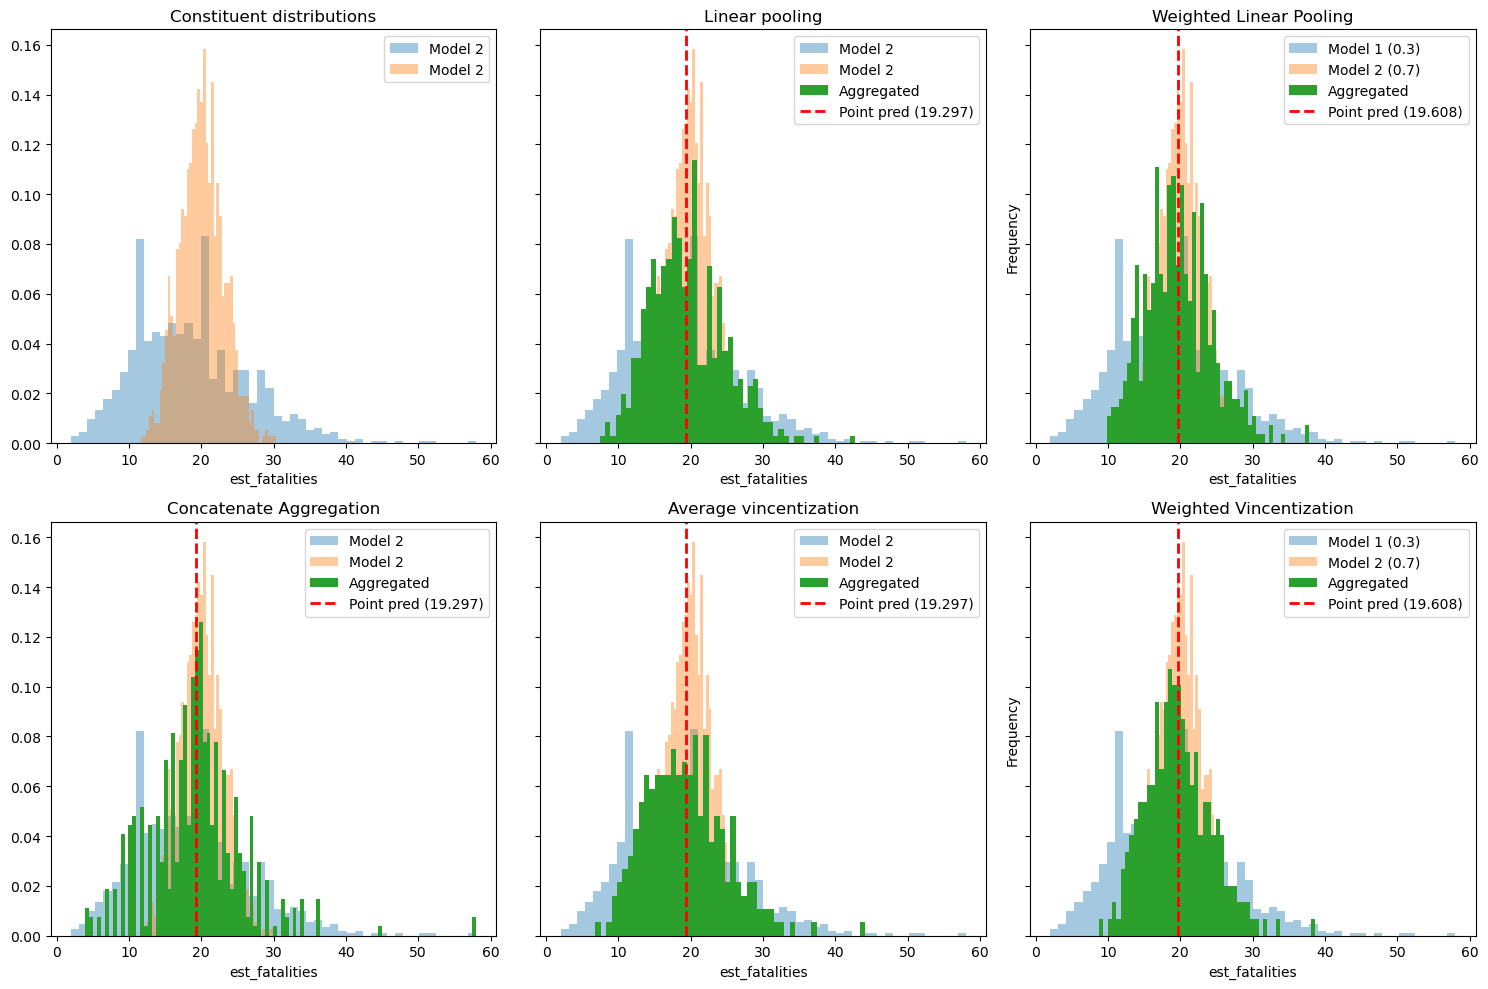

In [288]:
# Take the pooled samples for one target, one entity
pooled_weighted = ensemble_distributions_w.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
pooled_average = ensemble_distributions_a.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
pooled_concat = ensemble_distributions_c.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
pooled_vincent_weight = ensemble_distributions_vw.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
pooled_vincent_average = ensemble_distributions_va.filter(pl.col("entity_id") == 1)["est_fatalities"][0]

# Take the point predictinos
point_w = point_distributions_w.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
point_a = point_distributions_a.filter(pl.col("entity_id") == 1)["est_fatalities"][0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

# Original distributions
axes[0,0].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[0,0].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[0,0].set_title("Constituent distributions")
axes[0,0].set_xlabel("est_fatalities")
axes[0,0].legend()

# Average pooling
axes[0,1].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[0,1].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[0,1].hist(pooled_average, bins=50, alpha=1, density=True, label="Aggregated")
axes[0,1].axvline(point_a, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_a:.3f})")
axes[0,1].set_title("Linear pooling")
axes[0,1].set_xlabel("est_fatalities")
axes[0,1].legend()

# Weighted pooling
axes[0,2].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label=f"Model 1 ({synth_manager.weights[0]})")
axes[0,2].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label=f"Model 2 ({synth_manager.weights[1]})")
axes[0,2].hist(pooled_weighted, bins=50, alpha=1, density=True, label="Aggregated")
axes[0,2].axvline(point_w, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_w:.3f})")
axes[0,2].set_title("Weighted Linear Pooling")
axes[0,2].set_xlabel("est_fatalities")
axes[0,2].set_ylabel("Frequency")
axes[0,2].legend()

# Concat pooling
axes[1,0].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[1,0].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[1,0].hist(pooled_concat, bins=100, alpha=1, density=True, label="Aggregated")
axes[1,0].axvline(point_a, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_a:.3f})")
axes[1,0].set_title("Concatenate Aggregation")
axes[1,0].set_xlabel("est_fatalities")
axes[1,0].legend()

# Average vincentization
axes[1,1].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[1,1].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label="Model 2")
axes[1,1].hist(pooled_vincent_average, bins=50, alpha=1, density=True, label="Aggregated")
axes[1,1].axvline(point_a, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_a:.3f})")
axes[1,1].set_title("Average vincentization")
axes[1,1].set_xlabel("est_fatalities")
axes[1,1].legend()

# Weighted vincentization
axes[1,2].hist(est_fatalities_m1[0], bins=50, alpha=0.4, density=True, label=f"Model 1 ({synth_manager.weights[0]})")
axes[1,2].hist(est_fatalities_m2[0], bins=50, alpha=0.4, density=True, label=f"Model 2 ({synth_manager.weights[1]})")
axes[1,2].hist(pooled_vincent_weight, bins=50, alpha=1, density=True, label="Aggregated")
axes[1,2].axvline(point_w, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point_w:.3f})")
axes[1,2].set_title("Weighted Vincentization")
axes[1,2].set_xlabel("est_fatalities")
axes[1,2].set_ylabel("Frequency")
axes[1,2].legend()

plt.tight_layout()
plt.show()

In [292]:
n_samples_per_model = 1000

# set random seed
np.random.seed(42)


distribution_1 = np.random.negative_binomial(n=8, p=0.3, size=n_samples_per_model)
distribution_2 = np.random.normal(loc=25, scale=3, size=n_samples_per_model)

pdf1 = pl.DataFrame({
    "time": [1,],
    "entity_id": [1,],
    "est_fatalities": pl.Series("est_fatalities", [distribution_1.tolist()], dtype=pl.List(pl.Float64)),
})

pdf2 = pl.DataFrame({
    "time": [1,],
    "entity_id": [1,],
    "est_fatalities": pl.Series("est_fatalities", [distribution_2.tolist()], dtype=pl.List(pl.Float64)),
})

# manager setup
dist_manager = AggregationManager(
    index_cols=["time", "entity_id"],
    target_cols=["est_fatalities"],
    weights=[0.3, 0.7],  # different weights
)

# add models
dist_manager.add_model(pdf1)
dist_manager.add_model(pdf2)

# retrieve aggregations with different methods
ensemble_distributions_w = dist_manager.aggregate_distributions("weighted", n_samples=500)
ensemble_distributions_a = dist_manager.aggregate_distributions("average", n_samples=500)
ensemble_distributions_c = dist_manager.aggregate_distributions("concat", n_samples=500)

# retrieve point predictions
point_distributions_w = dist_manager.aggregate_point_predictions("mean")
point_distributions_a = dist_manager.aggregate_point_predictions(use_weights=False)

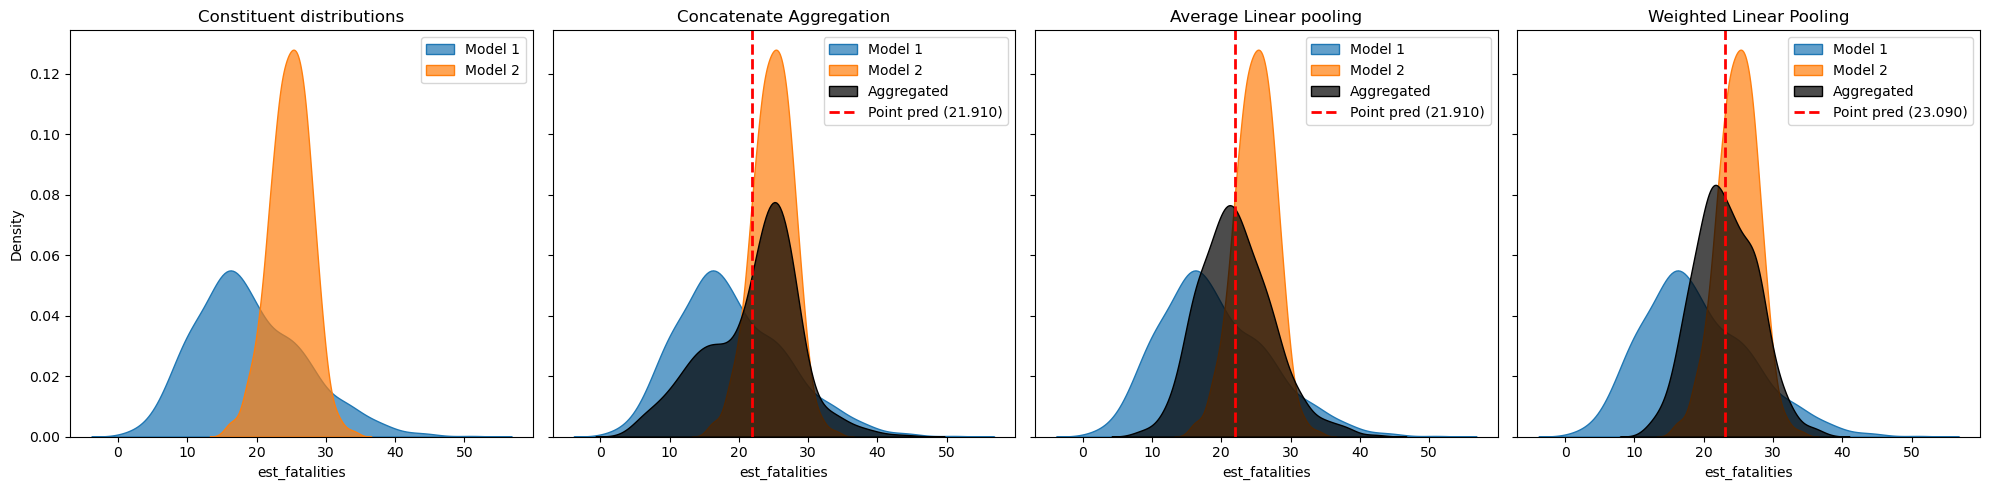

In [290]:
import seaborn as sns
import matplotlib.pyplot as plt

# Take the pooled samples for one target, one entity
pooled_weighted = ensemble_distributions_w["est_fatalities"][0]
pooled_average = ensemble_distributions_a["est_fatalities"][0]
pooled_concat = ensemble_distributions_c["est_fatalities"][0]

# Take the point predictions
point_w = point_distributions_w.filter(pl.col("entity_id") == 1)["est_fatalities"][0]
point_a = point_distributions_a.filter(pl.col("entity_id") == 1)["est_fatalities"][0]

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

# Define a helper to plot KDEs
def plot_kde(ax, models, pooled=None, point=None, title=""):
    for i, data in enumerate(models):
        sns.kdeplot(data, ax=ax, fill=True, alpha=0.7, label=f"Model {i+1}")
    if pooled is not None:
        sns.kdeplot(pooled, ax=ax, fill=True, alpha=0.7, color="black", label="Aggregated")
    if point is not None:
        ax.axvline(point, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point:.3f})")
    ax.set_title(title)
    ax.set_xlabel("est_fatalities")
    ax.legend()

# Plot each aggregation
plot_kde(axes[0], [est_fatalities_m1[0], est_fatalities_m2[0]], title="Constituent distributions")
plot_kde(axes[1], [est_fatalities_m1[0], est_fatalities_m2[0]], pooled_concat, point_a, title="Concatenate Aggregation")
plot_kde(axes[2], [est_fatalities_m1[0], est_fatalities_m2[0]], pooled_average, point_a, title="Average Linear pooling")
plot_kde(axes[3], [est_fatalities_m1[0], est_fatalities_m2[0]], pooled_weighted, point_w, title="Weighted Linear Pooling")


plt.tight_layout()
plt.show()


In [363]:
def plot_distribution_aggregations(distribution_sets, weights=None, n_samples=1000, save=False):
    """
    Given a list of distribution sets (each set is a list of raw samples),
    create an AggregationManager for each set, perform aggregations, point predictions,
    and plot KDEs of the constituent distributions and all aggregation methods.

    Parameters
    ----------
    distribution_sets : list of list of lists
        Each element is a set of distributions (raw samples) to aggregate and plot.
        Example: [[dist1_model1, dist1_model2], [dist2_model1, dist2_model2, dist2_model3]]
    weights : list of floats or None
        Optional weights for weighted aggregation
    n_samples : int
        Number of samples for aggregation methods that require resampling
    """
    n_rows = len(distribution_sets)

    index_cols=["time", "entity_id"]
    target_cols=["est_fatalities"]

    fig, axes = plt.subplots(n_rows, 4, figsize=(20, 4*n_rows), sharey=True)
    fig.suptitle("Overview of Aggregation Methods", fontsize=16, y=0.99)

    if n_rows == 1:
        axes = [axes]

    for i, dist_set in enumerate(distribution_sets):
        # Create Polars DataFrames for each distribution
        model_dfs = []
        for dist in dist_set:

            df = pl.DataFrame({
                "time": [1,],
                "entity_id": [1,],
                "est_fatalities": pl.Series("est_fatalities", [dist], dtype=pl.List(pl.Float64)),
            })

            model_dfs.append(df)

        # Setup AggregationManager
        manager = AggregationManager(
            index_cols=index_cols,
            target_cols=target_cols,
            weights=weights,  # different weights
        )

        for df in model_dfs:
            manager.add_model(df)

        # Aggregations
        agg_methods = {
            "Concat": "concat",
            "Average": "average",
            "Weighted": "weighted",
        }

        # Compute point predictions (mean)
        point_pred_w = manager.aggregate_point_predictions("mean")
        point_pred_a = manager.aggregate_point_predictions(use_weights=False)

        # Plot original distributions
        ax = axes[i][0]
        for n, dist in enumerate(dist_set):
            sns.kdeplot(dist, ax=ax, fill=True, alpha=0.7, label=f"Model {n+1}")
        if i == 0:
            ax.set_title(f"Constituent distributions", size=15)
        ax.legend()

        # Plot each aggregation
        for j, (title, method) in enumerate(agg_methods.items()):
            try:
                pooled = manager.aggregate_distributions(method, n_samples=n_samples)
                pooled_samples = pooled[target_cols[0]][0]
            except ValueError:
                pooled_samples = None  # some methods might fail if weights missing

            models = [dist for dist in dist_set]


            ax = axes[i][j+1] if n_rows > 1 else axes[j+1]

            # Plot KDEs
            for k, data in enumerate(models):
                sns.kdeplot(data, ax=ax, fill=True, alpha=0.4, label=f"Model {k+1} ({weights[k]})" if "Weighted" in title else f"Model {k+1}")
            if pooled_samples is not None:
                sns.kdeplot(pooled_samples, ax=ax, fill=True, alpha=0.8,  label="Aggregated")
            # Add point predictions
            point = point_pred_w[target_cols[0]][0] if "Weighted" in title or "Vincent Weighted" in title else point_pred_a[target_cols[0]][0]
            ax.axvline(point, color="red", linestyle="--", linewidth=2, label=f"Point pred ({point:.2f})")
            if i == 0:
                ax.set_title(title, size=15)
            #ax.set_xlabel(target_cols[0])
            ax.legend()

    plt.tight_layout()

    if save:
        fig.savefig(f"figs/aggregation_overview.png")
    plt.show()


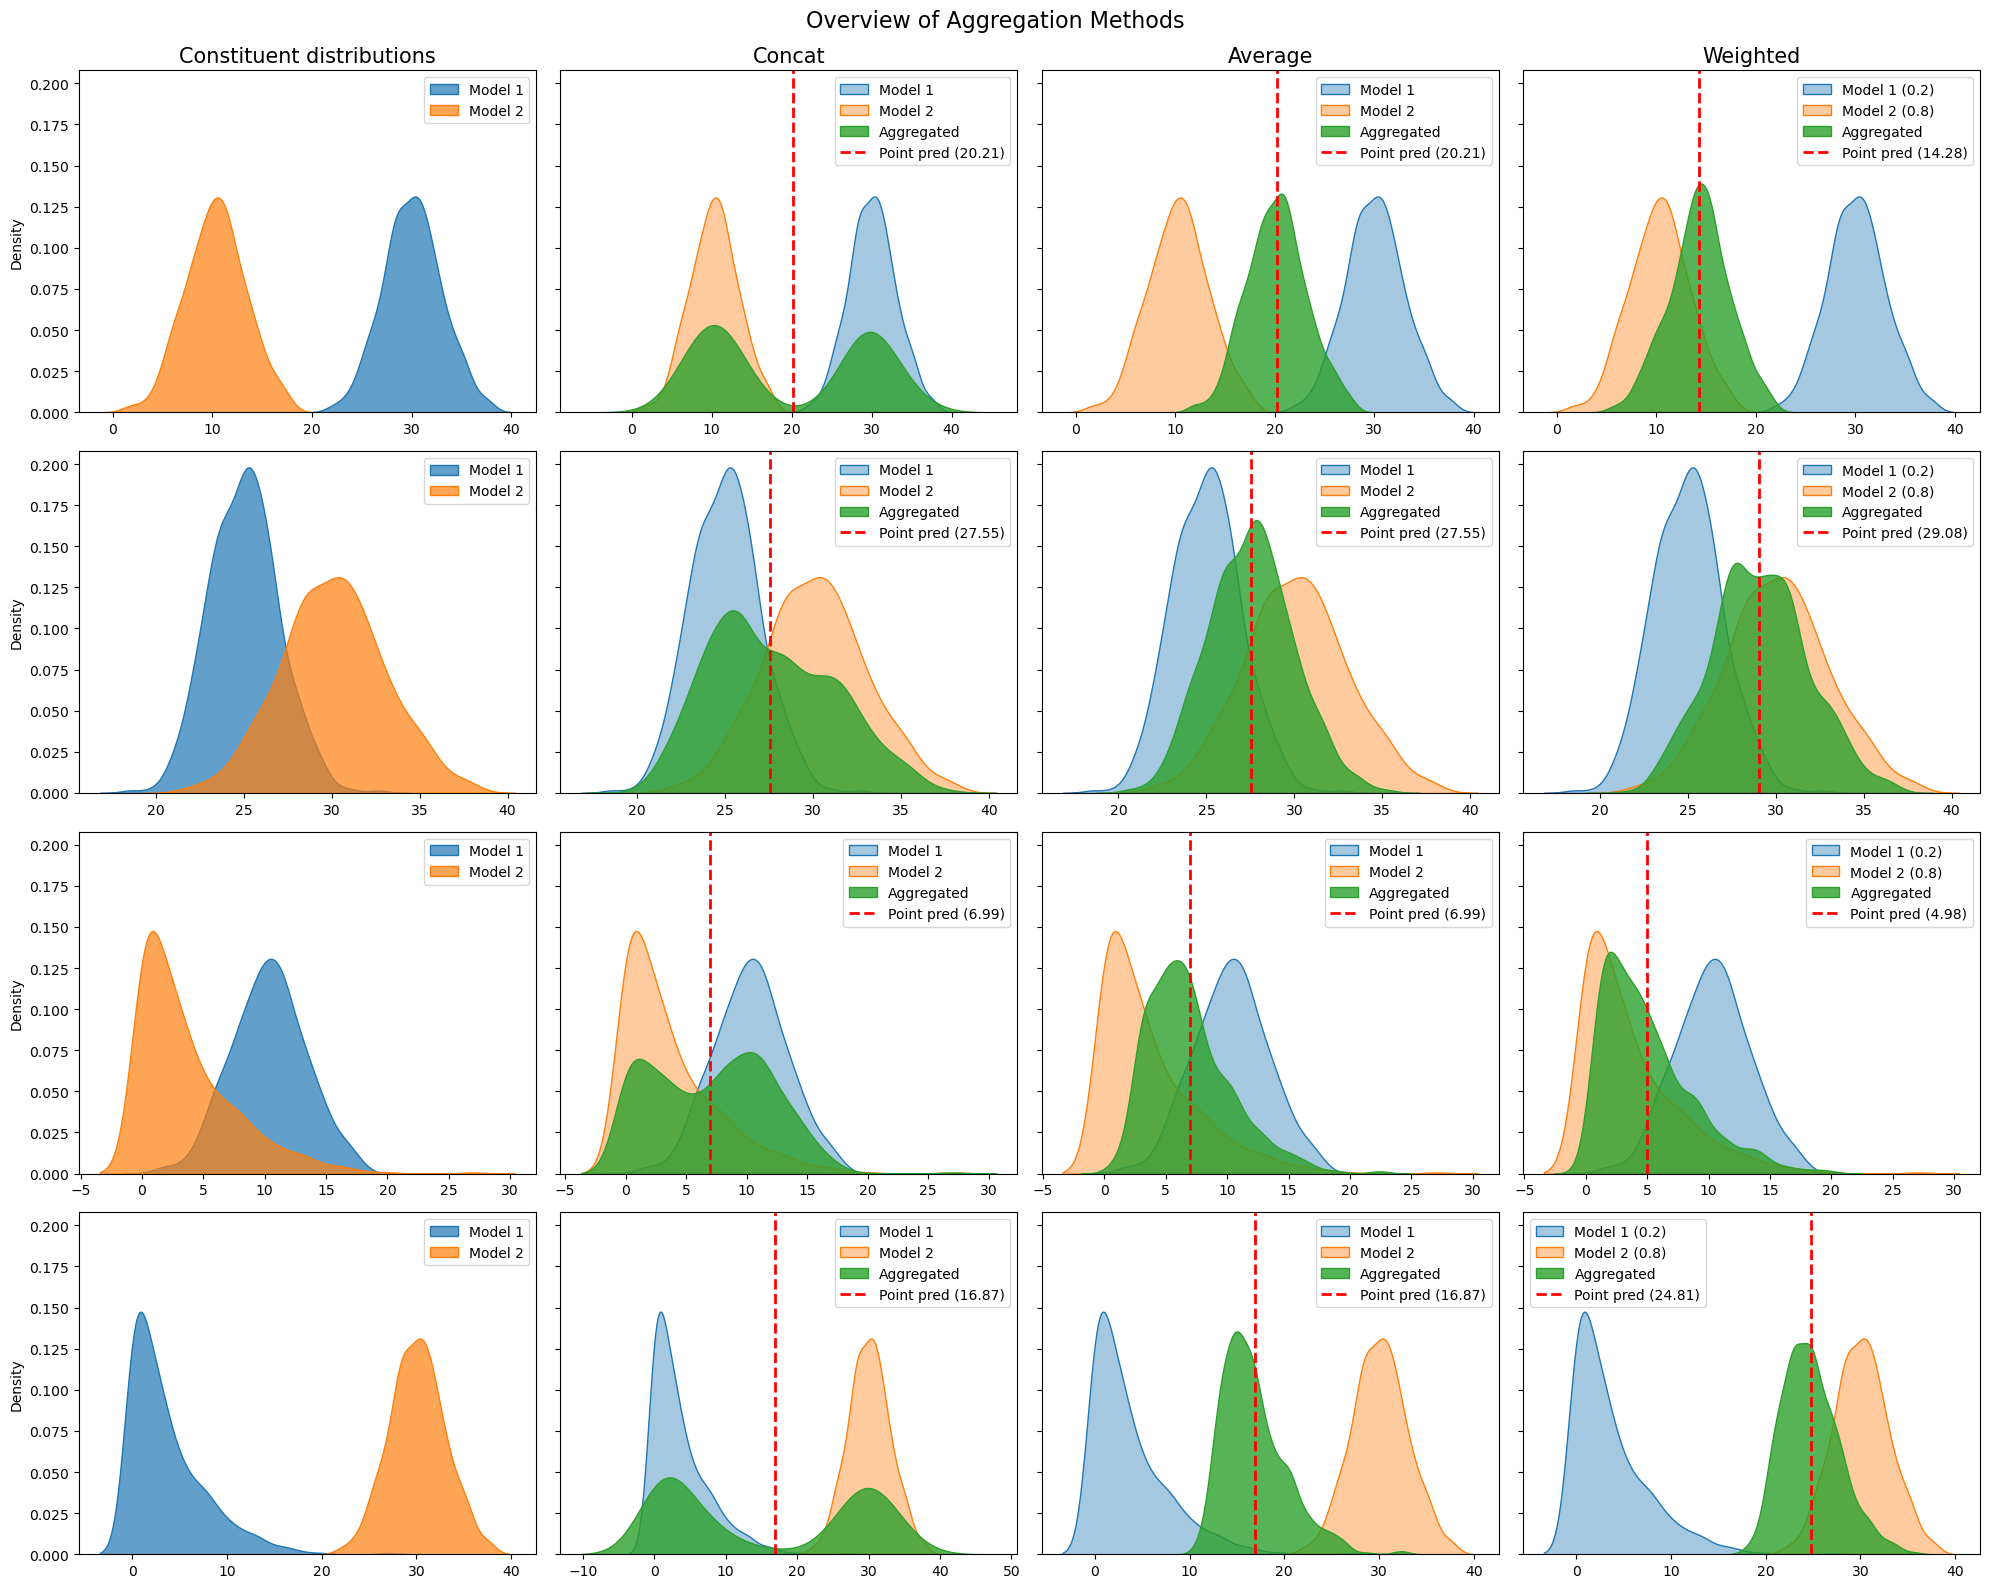

In [364]:
# Generate some synthetic distributions
np.random.seed(42)
dist1 = np.random.normal(25, 2, 500).tolist()
dist2 = np.random.normal(30, 3, 500).tolist()
dist3 = np.random.normal(10, 3, 500).tolist()
dist4 = np.random.negative_binomial(1, 0.2, 500).tolist()


distribution_sets = [
    [dist2, dist3],
    [dist1, dist2],
    [dist3, dist4],
    [dist4, dist2]
]

# plot aggregation results
plot_distribution_aggregations(distribution_sets, weights=[0.2, 0.8], save=True)
